# Impact of decimation in the automatic selection of the varifold kernel width using a decimation-based approach


Before, we showed [how a varifold kernel can be selected automatically using a decimation-based approach](../how_to/varifold_kernel_tuning.ipynb).

Here, we show some of the drawbacks of the method.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import polpo.preprocessing.dict as ppdict
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaBisecSearch
from polpo.preprocessing import BranchingPipeline, IdentityStep
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.decimation import PvDecimate

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
session_subset = np.random.choice(np.arange(1, 27))

mesh_loader = (
    MeshLoader(
        subject_subset=["01"],
        struct_subset=["L_Hipp"],
        session_subset=[session_subset],
        derivative="enigma",
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey(nested=True)
    + PvSurface
)

raw_mesh = mesh_loader()

session_subset

np.int64(21)

In [3]:
decimation_targets = [0.8, 0.5, 0.2, 0]


multi_decimation_pipe = BranchingPipeline(
    [
        (
            PvDecimate(target_reduction=target_reduction, volume_preservation=True)
            + PvSurface
            if target_reduction
            else IdentityStep()
        )
        for target_reduction in decimation_targets
    ],
    merger=lambda data: dict(zip(decimation_targets, data)),
)

meshes = multi_decimation_pipe(raw_mesh)


[mesh.n_points for mesh in meshes.values()]

[502, 1252, 2002, 2502]

How does decimation affect mass?

In [4]:
[np.sum(mesh.face_areas) for mesh in meshes.values()]

[np.float64(1734.77822369891),
 np.float64(1734.7171298008561),
 np.float64(1734.7350274907199),
 np.float64(1734.7065791328196)]

In [5]:
[np.sum(mesh.volume) for mesh in meshes.values()]

[np.float64(3478.998321966246),
 np.float64(3489.383964996294),
 np.float64(3490.5027858115213),
 np.float64(3490.617830330979)]

In [6]:
ref_value = 0.1

grid_search = SigmaBisecSearch(
    ref_value=ref_value,
    decimator=True,
)

In [7]:
sigmas = {}
sdists = {}

for target_red, mesh in meshes.items():
    grid_search.fit([mesh])

    sigmas[target_red] = grid_search.grid_.copy()
    sdists[target_red] = grid_search.sdists_.copy()

/home/luisfpereira/Repos/github/polpo/polpo/mesh/varifold/tuning.py:255: UserWarning: No convergence. Upper interval bound is too strict.
  warnings.warn("No convergence. Upper interval bound is too strict.")


(0.0, 0.4)

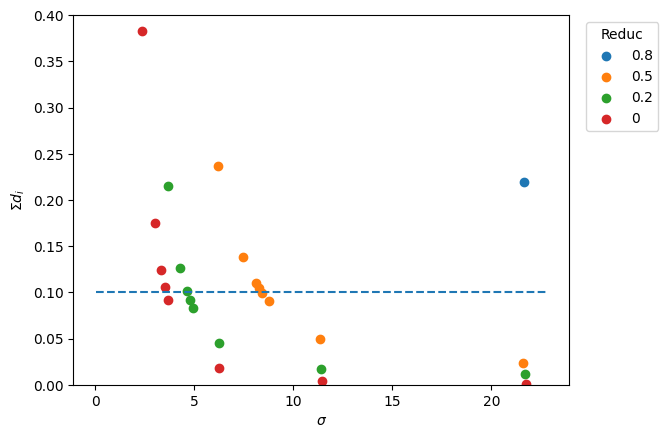

In [8]:
_, ax = plt.subplots()

for target_red in meshes:
    ax.scatter(sigmas[target_red], sdists[target_red], label=target_red)

x_min, x_max = ax.get_xlim()
ax.hlines(y=ref_value, xmin=x_min, xmax=x_max, linestyle="--")

ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\Sigma d_i$")
ax.legend(title="Reduc", bbox_to_anchor=(1.02, 1), loc="upper left")


ax.set_ylim([0, 0.4])

The culprit.

In [9]:
[np.amax(mesh.edge_lengths) for mesh in meshes.values()]

[np.float32(6.4342594),
 np.float32(4.1676106),
 np.float32(3.1141806),
 np.float64(2.0772219039275552)]

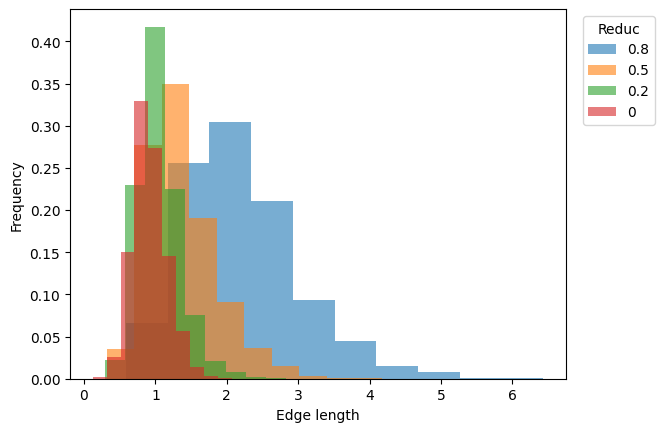

In [10]:
_, ax = plt.subplots()

for target_red, mesh in meshes.items():
    edge_lengths = mesh.edge_lengths
    ax.hist(
        edge_lengths,
        label=target_red,
        alpha=0.6,
        weights=1 / edge_lengths.size * np.ones_like(edge_lengths),
    )

ax.set_xlabel("Edge length")
ax.set_ylabel("Frequency")
ax.legend(title="Reduc", bbox_to_anchor=(1.02, 1), loc="upper left");

## Further reading

* [How to automatically select the varifold kernel?](../how_to/varifold_kernel_tuning.ipynb)

* [How much decimation is too much?](./decimation_charlen.ipynb)
